# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.6.0
# sklearn 0.24.2

## Setup

In [2]:
fit_SQ = 0

In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
import scipy.optimize as opt
import scipy.signal as sgnl
tf.config.run_functions_eagerly(True)

from scipy.signal import savgol_filter

Assign device (GPU)

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

In [6]:
def is_header(x):
    n_header = 2
    return x>=n_header

In [7]:
def loaddata(filename):
    with open(filename,'r') as fp:
        lines = fp.readlines()

    index_all = range(len(lines))
    index = list(filter(is_header, index_all))
    
    lines_data = list(itemgetter(*index)(lines))
    
    data_dict = {}
    for j, ld in enumerate(lines_data):
        raw_fields = struct_unpacker(ld.encode())
        ld_unpacked = {}
        for i in field_indices:
            fieldspec = fieldspecs[i]
            fieldname = fieldspec[iname]
            cast = fieldspec[itype]
            value = cast(raw_fields[i].decode().strip())
            ld_unpacked[fieldname] = [value]
        if j==0:
            data_dict = ld_unpacked
            continue
        data_dict = {key: [*data_dict[key], *ld_unpacked[key]] for key in data_dict}
    
    return data_dict

def get_struct_unpacker(fieldspecs, istart, iwidth):
    # https://gist.github.com/rochacbruno/059e1223f5b69d3b99b509a4962cf3aa
    """
    Build the format string for struct.unpack to use, based on the fieldspecs.
    fieldspecs is a list of [name, start, width] arrays.
    Returns a string like "6s4s8s7x7s4x9s".
    """
    unpack_len = 0
    unpack_fmt = ""
    for fieldspec in fieldspecs:
        start = fieldspec[istart] - 1
        end = start + fieldspec[iwidth]
        if start > unpack_len:
            unpack_fmt += str(start - unpack_len) + "x"
        unpack_fmt += str(end - start) + "s"
        unpack_len = end
    struct_unpacker = struct.Struct(unpack_fmt).unpack_from
    return struct_unpacker

from operator import itemgetter
import struct

fieldspecs = [
    # Name, Start, Width, Type
    ["Q (1/A)", 1, 12, float],
    ["I(Q) (1/cm)", 14, 12, float],
    ["std. dev. I(Q) (1/cm)", 27, 12, float],
    ["sigmaQ", 40, 12, float],
#     ["meanQ", 72, 8, float],
#     ["ShadowFactor", 95, 1, int]
]

iname, istart, iwidth, itype = 0, 1, 2, 3  # field indexes

fieldspecs.sort(key=itemgetter(istart))
struct_unpacker = get_struct_unpacker(fieldspecs, istart, iwidth)
field_indices = range(len(fieldspecs))

In [8]:
filename = './BB_CVSANS/BB-CVSANS-S5-027.dat'
data_dict = loaddata(filename)
print('loaded '+ filename)

loaded ./BB_CVSANS/BB-CVSANS-S5-027.dat


In [9]:
Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
IQ_data = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
IQ_er = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)
dQ = np.array(data_dict['sigmaQ']).astype(np.float32)

In [10]:
## trim
# for j in range(5):
#     for i in range(q_SAXS.shape[0]-2):
#         if (np.log(IQ_SAXS[i+1]/IQ_SAXS[i])>np.log(2))|(np.log(IQ_SAXS[i+1]/IQ_SAXS[i+2])>np.log(1.1)):
#             IQ_SAXS[i+1] = np.sqrt(IQ_SAXS[i]*IQ_SAXS[i+2])
#             SQ_SAXS[i+1] = np.sqrt(SQ_SAXS[i]*SQ_SAXS[i+2])
#             PQ_SAXS[i+1] = np.sqrt(PQ_SAXS[i]*PQ_SAXS[i+2])
# A = PQ_SAXS[0]

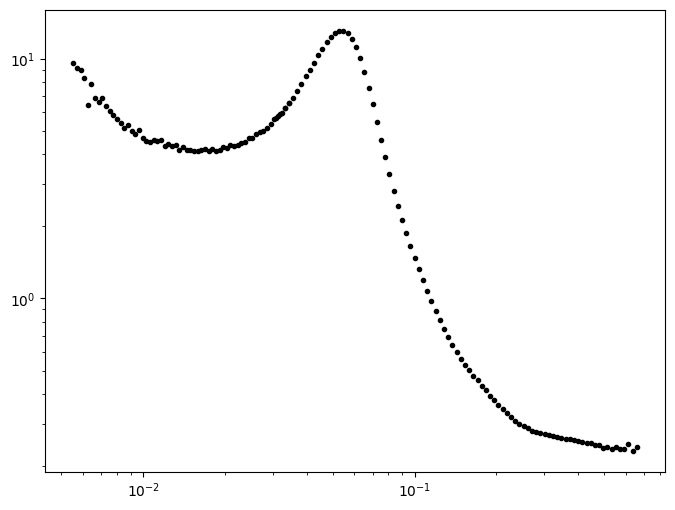

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ_data,'.k')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [12]:
print('Q_max = {}'.format(max(Q)))
print('Q_min = {}'.format(min(Q)))
print('Q_peak = {}'.format(Q[IQ_data==max(IQ_data)]))

Q_max = 0.6590474843978882
Q_min = 0.0055233389139175415
Q_peak = [0.05465661]


In [13]:
I_inc = np.mean(IQ_data[(Q>0.5)&(Q<=0.6)])

In [14]:
I_inc

0.23712286

$Q\cdot r_\textrm{ave}$

In [15]:
sq_dim = 80
sample_dim = 1

Rescale

In [16]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

In [17]:
'''
The input data is rescaled to the range such that 0.02<=QD<=16 
'''
r_HS = 3/0.05465661 # when Q = 0.04112146, Qr_HS = 3 (first peak)
d_HS = r_HS*2
print('d_HS = {}'.format(d_HS))
IQ_rs = np.zeros((sample_dim,q_rs_dim)) 
Qd_HS = Q*d_HS

# # extrapolate low-Q
i_fit = (Qd_HS>2) & (Qd_HS<4)
polycoeff = np.polyfit(Qd_HS[i_fit],IQ_data[i_fit],2)

i_lowQ = (Qd_HS<2)
IQ = IQ_data
IQ[i_lowQ] = Qd_HS[i_lowQ]**2*polycoeff[0] + Qd_HS[i_lowQ]**1*polycoeff[1] + Qd_HS[i_lowQ]**0*polycoeff[2]

# # rescale IQ to QD in [0,16]
f_IQ = interp.interp1d(Qd_HS[2:],IQ[2:],fill_value='extrapolate')
IQ_rs = f_IQ(q_rs).astype(np.float32)
IQ_rs[IQ_rs<=0] = 1e-5

# # rescale IQ_er to QD in [0,16]
f_IQ_er = interp.interp1d(Qd_HS[2:],IQ_er[2:],fill_value='extrapolate')
IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)

d_HS = 109.77629238256819


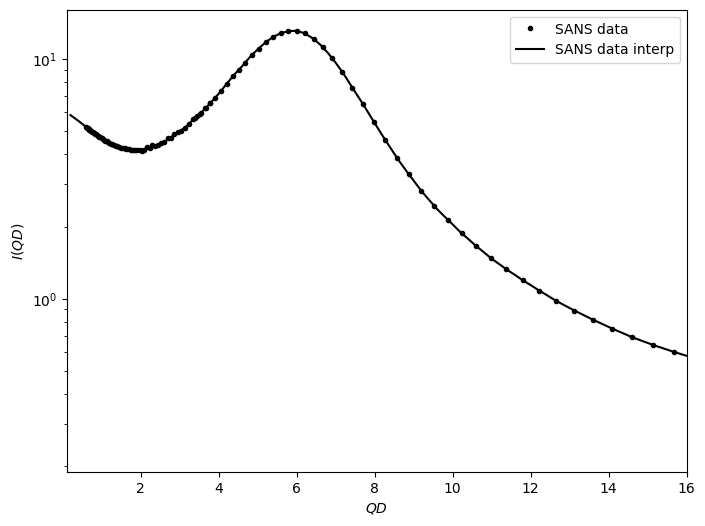

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Q*d_HS,IQ,'.k',label='SANS data')
ax.plot(q_rs,IQ_rs[:],'-k',label='SANS data interp')
ax.set_xlim([0.1,16])
# ax.set_ylim([0.1,30])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

In [19]:
q_rs_dim

80

### Resolution

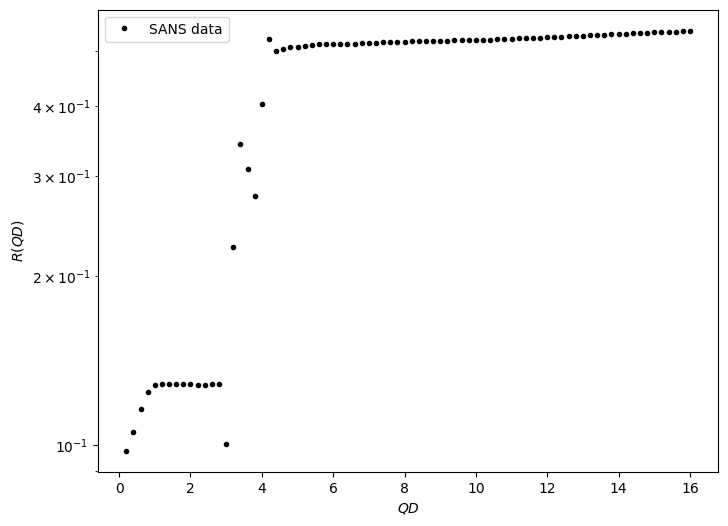

In [20]:
interpolating_function_dQ = interp.interp1d(Qd_HS[3:],dQ[3:],fill_value='extrapolate',kind= 'linear')
dQ_interp = interpolating_function_dQ(q).astype(np.float32)
dQ_sm = sgnl.savgol_filter(dQ_interp,5,3)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q,dQ_sm*d_HS,'.k',label='SANS data')
# ax.set_xlim([0,16])
# ax.set_ylim([5,2000])
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$R(QD)$')
ax.legend()
plt.show()

### Preprocess/Postprocess

In [21]:
exp_scale = 6

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

## Define functions 

In [22]:
from SQ_decoder import SQ_decoder

In [23]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [24]:
def softball_Q(Q, fp):
    R1, R2, sigma1, sigma2, rc = fp[2:7]
    j1 = lambda QR: (tf.math.sin(QR)-QR*tf.math.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*tf.math.exp(-(Qsigma/2)**2)/QR
    
    QR1 = Q*R1
    QR2 = Q*R2
    Qsigma1 = Q*sigma1
    Qsigma2 = Q*sigma2
    
    P = (rc*F1(QR1,Qsigma1) + (1-rc)*F1(QR2,Qsigma2))**2
    
    return P

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        IQ_resoln = IQ_th*(1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ.append(np.trapz(IQ_resoln,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out
    
def interpolation(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def SQ_th(fp):
    # structure factor
    return SQ_decoder(fp[7:10])

def IQ_th(fp):
    # form factor
    P = softball_Q(q, fp)
    
    # structure factor
    S = SQ_th(fp)
    
    # I(Q)
    if fit_SQ==1:
        IQ_th = S
    else:
        IQ_th = S*P*fp[0]+fp[1]
    
    # interpolation
    IQ_th_interp = interpolation(q,IQ_th,fp[10])
    
    # resolution
    IQ_th_smooth = IQ_resoln(q, q[1:], IQ_th_interp[1:], dQ_sm*r_HS*2*fp[10])
    return IQ_th_smooth

## Pick an I(Q) and test

In [25]:
IQ_exp = IQ_rs

### Initial value

In [26]:
export_path = './saved_model/SQ_cVAE_MSE_ns/'
with np.load(export_path +'lv_SVD_exp6.npz') as data:
    z_mean = data['z_mean']
    U = data['U']
    sgn = data['sgn']

In [27]:
def initial_guess_transform(lv_s = [0,0,0]):
    lv = np.matmul(lv_s*sgn,U.T) + z_mean
    return lv

In [28]:
initial_guess_transform(lv_s = [-0.7,0,0])

array([0.26856374, 0.16833674, 0.50916568])

In [29]:
'''
Fitting parameters:
fp = [C, I_inc, R1, R2, sigma_1, sigma_2, rc, lv_0, lv_1, lv_2, sigma]

I(Q) = C*P(Q)*S(Q) + I_inc
lv_0 to lv_2:  latent variables used in VAE to generate S(Q)
sigma: scaling parameter
'''

fp =         [100, 0.04, 30/d_HS,  60/d_HS, 15/d_HS, 20/d_HS, 0.4, 0.19,   0.03,    0.4,   1.15]
fp_ubounds = (200, 10,   60/d_HS, 100/d_HS, 30/d_HS, 40/d_HS, 1.0, 0.20,   0.04,    0.7,  1.25)
fp_lbounds = (1,   0,    20/d_HS,  20/d_HS,  5/d_HS, 10/d_HS, 0.0, 0.18,   0.02,    0.35,  1.1)
fp_bounds = [fp_lbounds,fp_ubounds]

In [30]:
def Fit_loss(fp):
    return ((IQ_exp)-(IQ_th(fp)))[(q>=1.5)&(q<=16)]
#     return (np.log(IQ_exp)-np.log(IQ_th(fp)))[(q>=1)&(q<=16)]

In [31]:
opti = opt.least_squares(Fit_loss,fp,bounds=fp_bounds, 
                         xtol = 1e-12, ftol = 1e-12,
                         x_scale='jac')

In [32]:
fp = opti.x
opti

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 0.3632183578741987
         fun: array([ 0.49063609,  0.29004523,  0.1309886 ,  0.07084683, -0.05354213,
       -0.1305607 , -0.12753107, -0.14375686, -0.13343514, -0.13033486,
       -0.11250459, -0.04101321, -0.06342286, -0.09456296,  0.01783196,
        0.0075481 ,  0.08795169,  0.08252229,  0.08435314,  0.06169806,
        0.03585838, -0.01174265,  0.01650103, -0.03958822, -0.10413618,
       -0.10834524, -0.09935952, -0.06939065, -0.01656863, -0.00127746,
        0.06580013,  0.11624302,  0.12678924,  0.12529182,  0.11676961,
        0.08701162,  0.07501699,  0.05567484,  0.01979391,  0.00560102,
       -0.01441271, -0.01653315, -0.02404546, -0.03987195, -0.04182206,
       -0.05000469, -0.04998162, -0.05592014, -0.04816198, -0.04542139,
       -0.03725109, -0.03413739, -0.02707946, -0.02492662, -0.02185473,
       -0.02266648, -0.02071623, -0.01964973, -0.02041905, -0.02166269,
       -0.02630632, -0.02985586, -

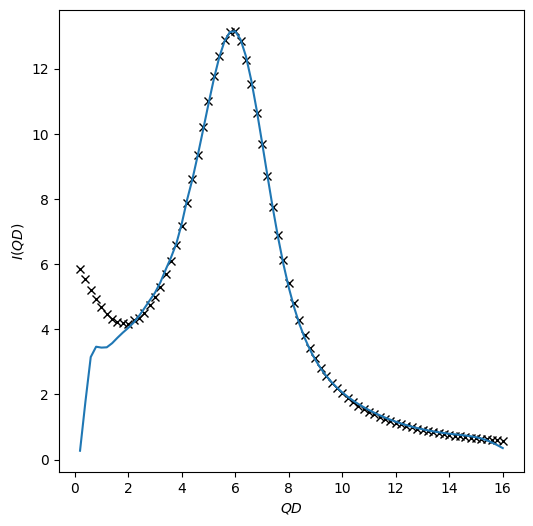

In [33]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
ax.plot(q,IQ_rs,'xk')
ax.plot(q,IQ_th(fp))

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

# ax.set_yscale('log')
plt.show()

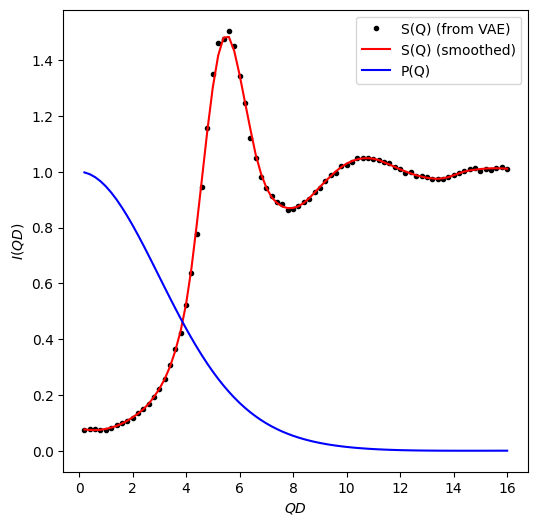

In [34]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(q,SQ_th(fp),'.k', label='S(Q) (from VAE)')
SQ_th_sm = savgol_filter(SQ_th(fp), 11,2)
ax.plot(q,SQ_th_sm,'-r', label='S(Q) (smoothed)')

ax.plot(q,softball_Q(q, fp),'-b', label='P(Q)')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

ax.legend()

# ax.set_yscale('log')
plt.show()

## Result potential parameters

In [35]:
dataname = 'S5'
datapath = './BB_CVSANS/'
scale = r_HS*2/fp[10]

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

In [37]:
export_path_GPR = './saved_model/GPR/' 
model_name_GPR_eta = 'sklearn/SQ_GPR_eta'
model_name_GPR_kappa = 'sklearn/SQ_GPR_kappa'
model_name_GPR_lnA = 'sklearn/SQ_GPR_lnA'
export_name_GPR_eta = export_path_GPR + model_name_GPR_eta
export_name_GPR_kappa = export_path_GPR + model_name_GPR_kappa
export_name_GPR_lnA = export_path_GPR + model_name_GPR_lnA
gp_eta = joblib.load(export_name_GPR_eta)
gp_kappa = joblib.load(export_name_GPR_kappa)
gp_lnA = joblib.load(export_name_GPR_lnA)

In [38]:
predict_eta = gp_eta.predict(SQ_th(fp).reshape((1,sq_dim)), return_std=True)
predict_kappa = gp_kappa.predict(SQ_th(fp).reshape((1,sq_dim)), return_std=True)
predict_lnA = gp_lnA.predict(SQ_th(fp).reshape((1,sq_dim)), return_std=True)
parameters_predict = [predict_eta,predict_kappa,predict_lnA]



In [39]:
print('Predictions: \n--- eta = {:0.4f} +- {:0.4f} \n--- kappa = {:0.4f} +- {:0.4f} (A)\n--- lnA = {:0.4f} +- {:0.4f}'
      .format(parameters_predict[0][0][0],parameters_predict[0][1][0],
              parameters_predict[1][0][0]*scale,parameters_predict[1][1][0]*scale,
              parameters_predict[2][0][0],parameters_predict[2][1][0]))

Predictions: 
--- eta = 0.2154 +- 0.0005 
--- kappa = 10.2291 +- 1.9967 (A)
--- lnA = 1.9010 +- 0.1934


## Result fitting parameters

In [40]:
# fitting parameters
print('scale = {} (A)'.format(scale))
print('C = {} (1/cm)'.format(fp[0]))
print('I_inc = {} (1/cm)'.format(fp[1]))
print('R_1 = {} (A)'.format(fp[2]*scale))
print('R_2 = {} (A)'.format(fp[3]*scale))
print('sigma_1 = {} (A)'.format(fp[4]*scale))
print('sigma_2 = {} (A)'.format(fp[5]*scale))
print('rc = {}'.format(fp[6]))
print('lv_0 = {}'.format(fp[7]))
print('lv_1 = {}'.format(fp[8]))
print('lv_2 = {}'.format(fp[9]))
print('\nPredictions: \n--- eta = {:0.4f} +- {:0.4f} \n--- kappa = {:0.4f} +- {:0.4f} (A)\n--- lnA = {:0.4f} +- {:0.4f}'
      .format(parameters_predict[0][0][0],parameters_predict[0][1][0],
              parameters_predict[1][0][0]*scale,parameters_predict[1][1][0]*scale,
              parameters_predict[2][0][0],parameters_predict[2][1][0]))

with open(datapath+'fp_' + dataname + '.txt', 'w') as f:
    f.write('scale = {} (A)\n'.format(scale))
    f.write('C = {} (1/cm)\n'.format(fp[0]))
    f.write('I_inc = {} (1/cm)\n'.format(fp[1]))
    f.write('R_1 = {} (A)\n'.format(fp[2]*scale))
    f.write('R_2 = {} (A)\n'.format(fp[3]*scale))
    f.write('sigma_1 = {} (A)\n'.format(fp[4]*scale))
    f.write('sigma_2 = {} (A)\n'.format(fp[5]*scale))
    f.write('rc = {}\n'.format(fp[6]))
    f.write('lv_0 = {}\n'.format(fp[7]))
    f.write('lv_1 = {}\n'.format(fp[8]))
    f.write('lv_2 = {}\n'.format(fp[9]))
    f.write('\nPredictions: \n--- eta = {:0.4f} +- {:0.4f} \n--- kappa = {:0.4f} +- {:0.4f} (A)\n--- lnA = {:0.4f} +- {:0.4f}'
      .format(parameters_predict[0][0][0],parameters_predict[0][1][0],
              parameters_predict[1][0][0]*scale,parameters_predict[1][1][0]*scale,
              parameters_predict[2][0][0],parameters_predict[2][1][0]))

 

scale = 93.61758326279144 (A)
C = 37.805236262799866 (1/cm)
I_inc = 0.6959527823865782 (1/cm)
R_1 = 29.102635131112706 (A)
R_2 = 51.95087162752047 (A)
sigma_1 = 11.724634238935266 (A)
sigma_2 = 22.78592385007543 (A)
rc = 0.5875205581311376
lv_0 = 0.1838181261880787
lv_1 = 0.021398537792309363
lv_2 = 0.4

Predictions: 
--- eta = 0.2154 +- 0.0005 
--- kappa = 10.2291 +- 1.9967 (A)
--- lnA = 1.9010 +- 0.1934


# Save S(Q) curve

In [41]:
qs = q/scale
f_interp = interp.interp1d(qs, SQ_th_sm, fill_value='extrapolate')
SQ_extracted = f_interp(Q)

from scipy.io import savemat
mdic = {'fp':fp, 'd_HS':d_HS,
       'SQ':SQ_extracted, 'Q':Q,
       'parameters':parameters_predict,
       'd_HS_scale':scale} 
'''
d_HS: initial guess of the hard sphere diameter
d_HS_scale = d_HS/fp[10]: scaled HS diameter after curve fitting
'''
savemat(datapath+dataname+'.mat', mdic)

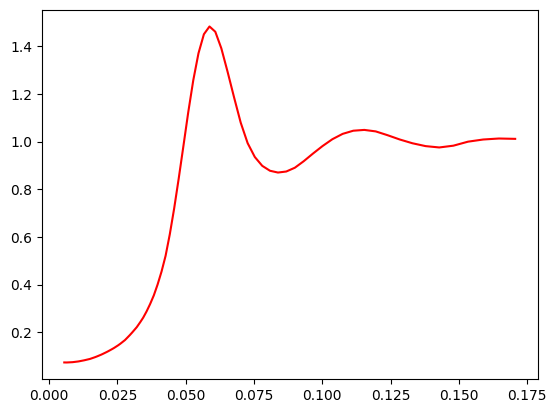

In [42]:
plt.plot(Q[Q<max(q)/scale],SQ_extracted[Q<max(q)/scale],'-r')
plt.show()